# Задание 1.1 - Метод К-ближайших соседей (K-neariest neighbor classifier)

В первом задании вы реализуете один из простейших алгоритмов машинного обучения - классификатор на основе метода K-ближайших соседей.
Мы применим его к задачам
- бинарной классификации (то есть, только двум классам)
- многоклассовой классификации (то есть, нескольким классам)

Так как методу необходим гиперпараметр (hyperparameter) - количество соседей, мы выберем его на основе кросс-валидации (cross-validation).

Наша основная задача - научиться пользоваться numpy и представлять вычисления в векторном виде, а также ознакомиться с основными метриками, важными для задачи классификации.

Перед выполнением задания:
- запустите файл `download_data.sh`, чтобы скачать данные, которые мы будем использовать для тренировки
- установите все необходимые библиотеки, запустив `pip install -r requirements.txt` (если раньше не работали с `pip`, вам сюда - https://pip.pypa.io/en/stable/quickstart/)

Если вы раньше не работали с numpy, вам может помочь tutorial. Например этот:  
http://cs231n.github.io/python-numpy-tutorial/

In [4]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [1]:
from dataset import load_svhn
from knn import KNN
from metrics import binary_classification_metrics, multiclass_accuracy

# Загрузим и визуализируем данные

В задании уже дана функция `load_svhn`, загружающая данные с диска. Она возвращает данные для тренировки и для тестирования как numpy arrays.

Мы будем использовать цифры из датасета Street View House Numbers (SVHN, http://ufldl.stanford.edu/housenumbers/), чтобы решать задачу хоть сколько-нибудь сложнее MNIST.

In [2]:
train_X, train_y, test_X, test_y = load_svhn("data", max_train=1000, max_test=100)

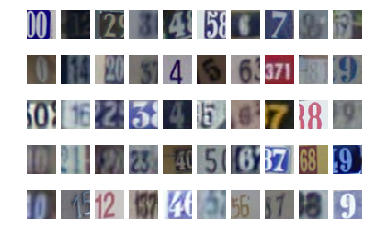

In [5]:
samples_per_class = 5  # Number of samples per class to visualize
plot_index = 1
for example_index in range(samples_per_class):
    for class_index in range(10):
        plt.subplot(5, 10, plot_index)
        image = train_X[train_y == class_index][example_index]
        plt.imshow(image.astype(np.uint8))
        plt.axis('off')
        plot_index += 1

In [21]:
binary_train_mask = (train_y == 0)
print(binary_train_mask)

[False False False False False False False False False False False False
 False  True False False  True False False False False False False  True
 False False False False False False False False  True False False False
 False False False False False False False False False False  True False
 False False False False False False False False False  True False False
 False False False False False False False False False  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
  True False False False False False False False False False  True False
 False  True  True False False False False False False  True False False
 False False False False False  True False False False False False False
 False False False False False False False False Fa

# Сначала реализуем KNN для бинарной классификации

В качестве задачи бинарной классификации мы натренируем модель, которая будет отличать цифру 0 от цифры 9.

In [127]:
# First, let's prepare the labels and the source data

# Only select 0s and 9s
binary_train_mask = (train_y == 0) | (train_y == 9)

binary_train_X = train_X[binary_train_mask]
binary_train_y = train_y[binary_train_mask] == 0

binary_test_mask = (test_y == 0) | (test_y == 9)

binary_test_X = test_X[binary_test_mask]
binary_test_y = test_y[binary_test_mask] == 0

# Reshape to 1-dimensional array [num_samples, 3*3*32]
#binary_train_X = binary_train_X.reshape(binary_train_X.shape[0], -1)
#binary_test_X = binary_test_X.reshape(binary_test_X.shape[0], -1)
#print(binary_test_X)

print(train_y)
print(binary_train_y)

[2 4 9 8 8 4 5 3 2 4 0 1 2 4 2 3 2 9 0 6 8 2 0 5 2 5 3 4 4 1 1 4 0 6 7 2 1
 1 2 6 9 3 1 0 5 3 1 3 1 3 1 5 8 0 1 7 5 9 7 9 2 2 8 6 5 5 2 2 9 3 5 6 4 2
 4 6 1 9 6 2 1 2 1 1 2 1 3 2 4 0 2 1 1 5 2 1 7 2 3 3 5 4 1 9 3 5 7 1 3 1 7
 0 1 8 1 0 6 3 6 0 6 2 2 2 2 5 2 1 4 6 2 4 1 1 1 6 2 1 2 3 9 7 6 6 7 1 7 5
 3 5 4 1 2 6 2 7 5 4 2 5 9 1 2 6 6 4 7 9 7 1 3 0 7 7 8 6 4 6 1 9 1 4 7 3 5
 1 1 8 3 8 1 8 3 6 6 9 3 4 5 4 0 6 7 3 4 5 7 3 0 9 1 1 3 1 7 2 2 4 0 3 2 9
 1 1 5 1 0 4 2 6 2 3 9 1 5 4 1 5 4 4 7 2 8 0 8 6 2 3 2 7 6 2 1 2 1 3 7 5 8
 5 1 2 4 7 5 2 1 1 4 4 1 5 8 7 9 3 7 1 9 1 2 6 2 6 3 4 4 4 8 1 9 3 7 4 3 3
 8 6 8 7 1 1 2 3 7 1 4 3 4 4 3 1 2 2 8 3 2 8 5 8 0 2 1 1 1 7 1 2 5 8 1 2 0
 1 3 2 5 1 7 2 5 0 1 2 1 3 5 7 4 1 3 4 9 8 5 5 2 2 4 7 7 2 3 1 4 4 0 1 3 3
 7 1 4 8 1 1 4 1 3 9 3 0 6 0 3 6 2 2 9 2 2 0 2 1 4 2 2 2 5 5 0 1 5 3 5 6 1
 2 5 8 4 3 3 0 1 3 3 5 3 3 2 4 8 0 4 3 2 3 3 1 6 9 5 7 2 4 5 2 3 2 8 6 6 3
 4 2 6 5 2 8 9 0 1 1 0 2 1 2 7 6 5 2 2 4 3 8 2 5 9 1 5 6 8 3 3 3 4 7 1 6 7
 3 4 6 2 5 2 4 0 1 4 3 3 

In [7]:
print(binary_train_X[0])
# Create the classifier and call fit to train the model
# KNN just remembers all the data
knn_classifier = KNN(k=1)
knn_classifier.fit(binary_train_X, binary_train_y)

[ 83. 104.  68. ...  68.  53.  56.]


## Пришло время написать код! 

Последовательно реализуйте функции `compute_distances_two_loops`, `compute_distances_one_loop` и `compute_distances_no_loops`
в файле `knn.py`

In [110]:
#print(knn_classifier.train_X.shape)

tr_X = np.array([[1, 2], [6,8], [7,1], [5,19], [5,3]]) 
te_X = np.array([[2,3], [8,1]])

n_train = tr_X.shape[0]
n_test = te_X.shape[0]

d = np.zeros((n_test,n_train),np.float32)
#print(d)
for i_test in range(te_X.shape[0]):
    for i_train in range(tr_X.shape[0]):
        d[i_test][i_train] = np.sum(np.abs(te_X[i_test] - tr_X[i_train]))
        
print(d)

# Пока изучим что к чему

# TODO: implement compute_distances_two_loops in knn.py
dists = knn_classifier.compute_distances_two_loops(binary_test_X)
#print(dists[0])
#print(np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))
assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))

[[ 2.  9.  7. 19.  3.]
 [ 8.  9.  1. 21.  5.]]


In [113]:
#tr_X = np.array([[1, 2], [6,8], [7,1]]) 
#te_X = np.array([[2,3], [8,1]])

#n_train = tr_X.shape[0]
#n_test = te_X.shape[0]

#d = np.zeros((n_test,n_train),np.float32)
#print(d)
#dd = np.sum(np.abs(tr_X - te_X[0]), axis=1)
#print(dd)
#print(np.sum(dd, axis=1))

#for i_test in range(n_test):
#    d[i_test] = np.sum(np.abs(tr_X - te_X[i_test]), axis=1)

#print(d)

# TODO: implement compute_distances_one_loop in knn.py
dists = knn_classifier.compute_distances_one_loop(binary_test_X)
print(dists[0])
assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))


[110803. 199133.  69349. 112399. 149819.  88151.  65002. 131779. 114530.
 192459. 222227. 122820. 123281. 109634.  75134.  98986. 178693. 110928.
 146836. 140466. 149820.  94660. 332498. 150431.  86988. 182902. 128857.
  69533. 154086. 149488. 129137. 164199. 132757. 131028. 103583. 115560.
  87638.  89488. 104779. 152119. 219671.  73884. 201238. 129493. 187146.
  86000. 178750. 161423. 318975. 219360. 221190.  73513. 111343.  92322.
 227034. 116175.  87051. 160256. 168131. 111536. 144755. 153299. 147971.
 111787. 137777.  93541. 234231.  82738. 195195.  96681. 153138.  93637.
  77330.  91629. 101261.  45855.  73867. 115721. 124903. 108368. 178000.
 160783. 107225. 265114.  79345. 128376. 239441.  98222. 151606. 214287.
 110846. 108908. 142919. 130401. 187418. 103118. 114895.  71441. 143093.
 122158. 101228. 170692.  80946. 192872.  60292.  87880.  80241. 363410.
  90590. 113785.  77768. 142441. 114939. 151798. 121181. 233905. 136148.
 244755. 129674. 122054. 175970.]


In [115]:
#tr_X = np.array([[1, 2], [6,8], [7,1], [5,19], [5,3]]) 
#te_X = np.array([[2,3], [8,1]])


#print()


#n_train = tr_X.shape[0]
#n_test = te_X.shape[0]

#print(n_train)
#print(n_test)
#xx = np.expand_dims(te_X, axis=1)

#print(np.sum(np.abs(tr_X - xx), axis=2))
#print(tr_X - xx)

#k = tr_X - te_X[0]
#d = np.subtract(tr_X, te_X[0])

#d = np.zeros((n_test,n_train),np.float32)
#print(k)
#print(d)
#x1 = np.arange(9.0).reshape(3,3)
#x2 = np.arange(3.0)

#print(x2[:,np.newaxis])
#dd = np.sum(np.abs(tr_X - te_X), axis=1)
#print(dd)

#for i_test in range(n_test):
#    d[i_test] = np.sum(np.abs(tr_X - te_X[i_test]), axis=1)

#print(d)

# TODO: implement compute_distances_no_loops in knn.py
dists = knn_classifier.compute_distances_no_loops(binary_test_X)
#print(dists[0])
assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))


In [119]:
# Lets look at the performance difference
%timeit knn_classifier.compute_distances_two_loops(binary_test_X)
%timeit knn_classifier.compute_distances_one_loop(binary_test_X)
%timeit knn_classifier.compute_distances_no_loops(binary_test_X)

15 ms ± 26.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.95 ms ± 17.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
11.5 ms ± 52.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [117]:
# TODO: implement predict_labels_binary in knn.py
prediction = knn_classifier.predict(binary_test_X)

In [ ]:
# TODO: implement binary_classification_metrics in metrics.py
precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print("KNN with k = %s" % knn_classifier.k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1)) 

In [ ]:
# Let's put everything together and run KNN with k=3 and see how we do
knn_classifier_3 = KNN(k=3)
knn_classifier_3.fit(binary_train_X, binary_train_y)
prediction = knn_classifier_3.predict(binary_test_X)

precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print("KNN with k = %s" % knn_classifier_3.k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1)) 

# Кросс-валидация (cross-validation)

Попробуем найти лучшее значение k! 

Для этого мы воспользуемся k-fold cross-validation (https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation). Мы разделим тренировочные данные на 5 фолдов (folds), и по очереди будем использовать каждый из них в качестве проверочных данных (validation data), а остальные -- в качестве тренировочных (training data).

В качестве финальной оценки эффективности k мы усредним значения F1 score на всех фолдах.
После этого мы просто выберем значение k с лучшим значением метрики.

*Бонус*: есть ли другие варианты агрегировать F1 score по всем фолдам? Напишите плюсы и минусы в клетке ниже.

In [ ]:
# Find the best k using cross-validation based on F1 score
num_folds = 5
train_folds_X = []
train_folds_y = []

# TODO: split the training data in 5 folds and store them in train_folds_X/train_folds_y

k_choices = [1, 2, 3, 5, 8, 10, 15, 20, 25, 50]
k_to_f1 = {}  # dict mapping k values to mean F1 scores (int -> float)

for k in k_choices:
    # TODO: perform cross-validation
    # Go through every fold and use it for testing and all other folds for validation
    # Perform training and produce F1 score metric on the validation dataset
    # Average F1 from all the folds and write it into k_to_f1

    pass

for k in sorted(k_to_f1):
    print('k = %d, f1 = %f' % (k, k_to_f1[k]))

### Проверим, как хорошо работает лучшее значение k на тестовых данных (test data)

In [ ]:
# TODO Set the best k to the best value found by cross-validation
best_k = 1

best_knn_classifier = KNN(k=best_k)
best_knn_classifier.fit(binary_train_X, binary_train_y)
prediction = best_knn_classifier.predict(binary_test_X)

precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print("Best KNN with k = %s" % best_k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1)) 

# Многоклассовая классификация (multi-class classification)

Переходим к следующему этапу - классификации на каждую цифру.

In [ ]:
# Now let's use all 10 classes
train_X = train_X.reshape(train_X.shape[0], -1)
test_X = test_X.reshape(test_X.shape[0], -1)

knn_classifier = KNN(k=1)
knn_classifier.fit(train_X, train_y)

In [ ]:
# TODO: Implement predict_labels_multiclass
predict = knn_classifier.predict(test_X)

In [ ]:
# TODO: Implement multiclass_accuracy
accuracy = multiclass_accuracy(predict, test_y)
print("Accuracy: %4.2f" % accuracy)

Снова кросс-валидация. Теперь нашей основной метрикой стала точность (accuracy), и ее мы тоже будем усреднять по всем фолдам.

In [ ]:
# Find the best k using cross-validation based on accuracy
num_folds = 5
train_folds_X = []
train_folds_y = []

# TODO: split the training data in 5 folds and store them in train_folds_X/train_folds_y

k_choices = [1, 2, 3, 5, 8, 10, 15, 20, 25, 50]
k_to_accuracy = {}

for k in k_choices:
    # TODO: perform cross-validation
    # Go through every fold and use it for testing and all other folds for validation
    # Perform training and produce accuracy metric on the validation dataset
    # Average accuracy from all the folds and write it into k_to_accuracy
    pass

for k in sorted(k_to_accuracy):
    print('k = %d, accuracy = %f' % (k, k_to_accuracy[k]))

### Финальный тест - классификация на 10 классов на тестовой выборке (test data)

Если все реализовано правильно, вы должны увидеть точность не менее **0.2**.

In [ ]:
# TODO Set the best k as a best from computed
best_k = 1

best_knn_classifier = KNN(k=best_k)
best_knn_classifier.fit(train_X, train_y)
prediction = best_knn_classifier.predict(test_X)

# Accuracy should be around 20%!
accuracy = multiclass_accuracy(prediction, test_y)
print("Accuracy: %4.2f" % accuracy)